In [1]:
!pip install DataSynthesizer
import pandas as pd
from datetime import date
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns

from DataSynthesizer.datatypes.utils.DataType import DataType
from DataSynthesizer.DataDescriber import DataDescriber
from DataSynthesizer.DataGenerator import DataGenerator
from DataSynthesizer.ModelInspector import ModelInspector
from DataSynthesizer.lib.utils import read_json_file, display_bayesian_network

import xgboost
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import fbeta_score
from sklearn.metrics import make_scorer

import time

     |████████████████████████████████| 23.1 MB 1.8 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [2]:
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    f, ax = plt.subplots(1,1)

    f.set_size_inches(18.5, 10.5)
    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.legend(loc="best", fontsize=15)
    ax.grid('on')

In [3]:
mergedData = pd.read_excel('TabellaFinaleSenzaNaN.xlsx', sheet_name=None)

In [4]:
mergedData['Sheet1'].head()

Unnamed: 0  HDN_CODE  Sesso  ...  SF36 general health Resilience  Outcome
0           0      2236      0  ...                   75         64        1
1           1      6426      0  ...                   10         54        0
2           2      8377      0  ...                   -1         -1       -1
3           3     11463      0  ...                   -1         -1       -1
4           4     11463      0  ...                   90         88        3

[5 rows x 81 columns]

In [5]:
# tolgo la prima colonna e seleziono il primo foglio
df = mergedData['Sheet1'].iloc[:, 1:]

In [6]:
df.head()

HDN_CODE  Sesso  ETA  ... SF36 general health  Resilience  Outcome
0      2236      0   64  ...                  75          64        1
1      6426      0   48  ...                  10          54        0
2      8377      0   56  ...                  -1          -1       -1
3     11463      0   71  ...                  -1          -1       -1
4     11463      0   71  ...                  90          88        3

[5 rows x 80 columns]

In [7]:
df.to_csv('TabellaFinaleInput.csv', index=False)
df.to_excel('TabellaFinaleInput.xlsx', index=False)

## Parametri utente

In [8]:
input_data = 'TabellaFinaleInput.csv' 
mode = 'correlated_attribute_mode'
#description_file = 'description_500_completa_correlated_datatypes_0_degree_no_nan.json'
description_file = 'description_definitiva_-1.json'
synthetic_data = 'synthetic_data_-1_def.csv'

In [9]:
#for col in df.columns:
#    print(f'\'{col}\': False,')

In [10]:
# An attribute is categorical if its domain size is less than this threshold.
threshold_value = 20

attr_to_datatype = {'HDN_CODE': DataType.INTEGER,
                    'Sesso': DataType.INTEGER,
                    'ETA': DataType.INTEGER,
                    'DATA': DataType.DATETIME,
                    'ASCVD_Score': DataType.FLOAT,
                    'DATA_INT': DataType.INTEGER,
                    'num_visita': DataType.INTEGER,
                    'Charlson_Diabete': DataType.INTEGER,
                    'Stifness': DataType.FLOAT,
                    'CAP': DataType.INTEGER ,
                    'FrailtyPhenotypeBool': DataType.INTEGER ,
                    'EGA_HB': DataType.FLOAT,
                    'EGA_PaO2': DataType.FLOAT ,
                    'EGA_SatO2': DataType.FLOAT ,
                    'Pneumo_ProveFunzResp_FEV_FVCPre': DataType.FLOAT ,
                    'Pneumo_ProveFunzResp_MEP': DataType.FLOAT ,
                    'Pneumo_ProveFunzResp_MIP': DataType.FLOAT ,
                    'Pneumo_ScalaBorg': DataType.FLOAT ,
                    'TestCammino6Min_BorgBase': DataType.FLOAT ,
                    'TestCammino6Min_BorgEnd': DataType.FLOAT ,
                    'TestCammino6Min_Distanza': DataType.INTEGER ,
                    'Alcool': DataType.INTEGER ,
                    'BMI': DataType.FLOAT ,
                    'BMI_Ricovero': DataType.FLOAT ,
                    'BMIPostRicovero': DataType.FLOAT ,
                    'Fumatore': DataType.INTEGER ,
                    'Pack_years': DataType.INTEGER ,
                    'Sintomi_Cadute': DataType.INTEGER ,
                    'Sintomi_DifficoltaDeglutizione': DataType.INTEGER ,
                    'Sintomi_DistUdito': DataType.INTEGER ,
                    'Sintomi_DistVista': DataType.INTEGER ,
                    'SintomiNeuropsico_Ageusia': DataType.INTEGER ,
                    'SintomiNeuropsico_Anosmia': DataType.INTEGER ,
                    'SintomiNeuropsico_Astenia': DataType.INTEGER ,
                    'SintomiNeuropsico_CognitivoAttenzione': DataType.INTEGER ,
                    'SintomiNeuropsico_CognitivoConcentrazione': DataType.INTEGER ,
                    'SintomiNeuropsico_CognitivoMemoria': DataType.INTEGER ,
                    'SintomiNeuropsico_DistEquilibrio': DataType.INTEGER ,
                    'SintomiNeuropsico_DistSonno': DataType.INTEGER ,
                    'SintomiNeuropsico_DoloriMuscolari': DataType.INTEGER ,
                    'SintomiNeuropsico_Effluvium': DataType.INTEGER ,
                    'VitaCm': DataType.INTEGER ,
                    'CALORIE': DataType.INTEGER ,
                    'PROTEINE_Perc': DataType.FLOAT ,
                    'CogStateScore_Esito': DataType.INTEGER ,
                    'GlobuliBianchi': DataType.INTEGER ,
                    'Linfociti_Assoluti': DataType.INTEGER ,
                    'Neutrofili':DataType.FLOAT  ,
                    'Piastrine': DataType.INTEGER ,
                    'GPT_ALT': DataType.INTEGER ,
                    'D_dimero': DataType.INTEGER ,
                    'Fibrinogeno': DataType.INTEGER ,
                    'Glicemia': DataType.INTEGER ,
                    'INSULINA': DataType.FLOAT ,
                    'PCR': DataType.FLOAT ,
                    
                    'DurataRicovero': DataType.INTEGER ,
                    'TempoDallaVisita': DataType.INTEGER ,
                    
                    'Descrizione': DataType.INTEGER ,
                    'AssumePiuFarmaciGiorno': DataType.INTEGER ,
                    'PersoPeso': DataType.INTEGER ,
                    'CamminareMenoUltimoAnno': DataType.INTEGER ,
                    'CaduteUltimoAnno':  DataType.INTEGER,
                    'SentirsiSolo': DataType.INTEGER ,
                    'PuoContareSuQualcuno': DataType.INTEGER ,
                    'DifficoltaEconomicheSpeseSanitarie': DataType.INTEGER ,
                    'EQ5D5L': DataType.FLOAT ,
                    'EQ5D5L health score': DataType.INTEGER ,
                    'Intrinsic Capacity (%)': DataType.FLOAT ,
                    'DASS21 stress': DataType.INTEGER ,
                    'Stress level': DataType.INTEGER ,
                    'DASS21 anxiety': DataType.INTEGER ,
                    'Anxiety level': DataType.INTEGER ,
                    'DASS21 depression': DataType.INTEGER ,
                    'Depression level': DataType.INTEGER ,
                    'Insomnia severity index': DataType.INTEGER ,
                    'ISI level': DataType.INTEGER ,
                    'SF36 general health': DataType.INTEGER ,
                    'Resilience': DataType.INTEGER,
                    'Outcome': DataType.INTEGER}

# specify categorical attributes
categorical_attributes = {#'HDN_CODE': False,
                          'Sesso': True,
                          #'ETA': False,
                          #'DATA': False,
                          #'ASCVD_Score': False,
                          #'DATA_INT': False,
                          'num_visita': True,
                          'Charlson_Totale': True,
                          'Charlson_Diabete': True,
                          #'Stifness': False,
                          #'CAP': False,
                          'FrailtyPhenotypeBool': True,
                          #'EGA_HB': False,
                          #'EGA_PaO2': False,
                          #'EGA_SatO2': False,
                          #'Pneumo_ProveFunzResp_FEV_FVCPre': False,
                          #'Pneumo_ProveFunzResp_MEP': False,
                          #'Pneumo_ProveFunzResp_MIP': False,
                          'Pneumo_ScalaBorg': True,
                          'TestCammino6Min_BorgBase': True,
                          'TestCammino6Min_BorgEnd': True,
                          #'TestCammino6Min_Distanza': False,
                          'Alcool': True,
                          #'BMI': False,
                          #'BMI_Ricovero': False,
                          #'BMIPostRicovero': False,
                          'Fumatore': True,
                          #'Pack_years': False,
                          'Sintomi_Cadute': True,
                          'Sintomi_DifficoltaDeglutizione': True,
                          'Sintomi_DistUdito': True,
                          'Sintomi_DistVista': True,
                          'SintomiNeuropsico_Ageusia': True,
                          'SintomiNeuropsico_Anosmia': True,
                          'SintomiNeuropsico_Astenia': True,
                          'SintomiNeuropsico_CognitivoAttenzione': True,
                          'SintomiNeuropsico_CognitivoConcentrazione': True,
                          'SintomiNeuropsico_CognitivoMemoria': True,
                          'SintomiNeuropsico_DistEquilibrio': True,
                          'SintomiNeuropsico_DistSonno': True,
                          'SintomiNeuropsico_DoloriMuscolari': True,
                          'SintomiNeuropsico_Effluvium': True,
                          #'VitaCm': False,
                          #'CALORIE': False,
                          #'PROTEINE_Perc': False,
                          'CogStateScore_Esito': True,
                          #'GlobuliBianchi': False,
                          #'Linfociti_Assoluti': False,
                          #'Neutrofili': False,
                          #'Piastrine': False,
                          #'GPT_ALT': False,
                          #'D_dimero': False,
                          #'Fibrinogeno': False,
                          #'Glicemia': False,
                          #'INSULINA': False,
                          #'PCR': False,
                          
                          #'DurataRicovero': False,
                          #'TempoDallaVisita': False,
                          
                          'Descrizione': True,
                          'AssumePiuFarmaciGiorno': True,
                          'PersoPeso': True,
                          'CamminareMenoUltimoAnno': True,
                          'CaduteUltimoAnno': True,
                          'SentirsiSolo': True,
                          'PuoContareSuQualcuno': True,
                          'DifficoltaEconomicheSpeseSanitarie': True,
                          #'EQ5D5L': False,
                          #'EQ5D5L health score': False,
                          #'Intrinsic Capacity (%)': False,
                          #'DASS21 stress': True,
                          'Stress level': True,
                          #'DASS21 anxiety': True,
                          'Anxiety level': True,
                          #'DASS21 depression': True,
                          'Depression level': True,
                          #'Insomnia severity index': True,
                          'ISI level': True,
                          #'SF36 general health': False,
                          #'Resilience': False
                          'Outcome':True}

# specify which attributes are candidate keys of input dataset.
candidate_keys = {'HDN_CODE':True}

# A parameter in Differential Privacy. It roughly means that removing a row in the input dataset will not 
# change the probability of getting the same output more than a multiplicative difference of exp(epsilon).
# Increase epsilon value to reduce the injected noises. Set epsilon=0 to turn off differential privacy.
epsilon = 0

# The maximum number of parents in Bayesian network, i.e., the maximum number of incoming edges.
degree_of_bayesian_network = 2

# Number of tuples generated in synthetic dataset.
num_tuples_to_generate = 5000

In [ ]:
# istanzio il data describer
describer = DataDescriber()
describer.describe_dataset_in_correlated_attribute_mode(dataset_file=input_data, 
                                                        epsilon=epsilon,
                                                        k=degree_of_bayesian_network,
                                                        attribute_to_datatype=attr_to_datatype,
                                                        attribute_to_is_categorical=categorical_attributes,
                                                        attribute_to_is_candidate_key=candidate_keys)
describer.save_dataset_description_to_file(description_file)

In [ ]:
display_bayesian_network(describer.bayesian_network)

In [ ]:
generator = DataGenerator()
generator.generate_dataset_in_correlated_attribute_mode(num_tuples_to_generate, description_file)
generator.save_synthetic_data(synthetic_data)

In [11]:
dfs = pd.read_csv(synthetic_data)

## Ispector

In [12]:
# Read both datasets using Pandas.
input_df = df
synthetic_df = dfs.iloc[:, 1:]
# Read attribute description from the dataset description file.
attribute_description = read_json_file(description_file)['attribute_description']
inspector = ModelInspector(input_df, synthetic_df, attribute_description)

In [ ]:
for attribute in synthetic_df.columns:
    inspector.compare_histograms(attribute)

In [13]:
frames = [df, dfs]

result = pd.concat(frames)

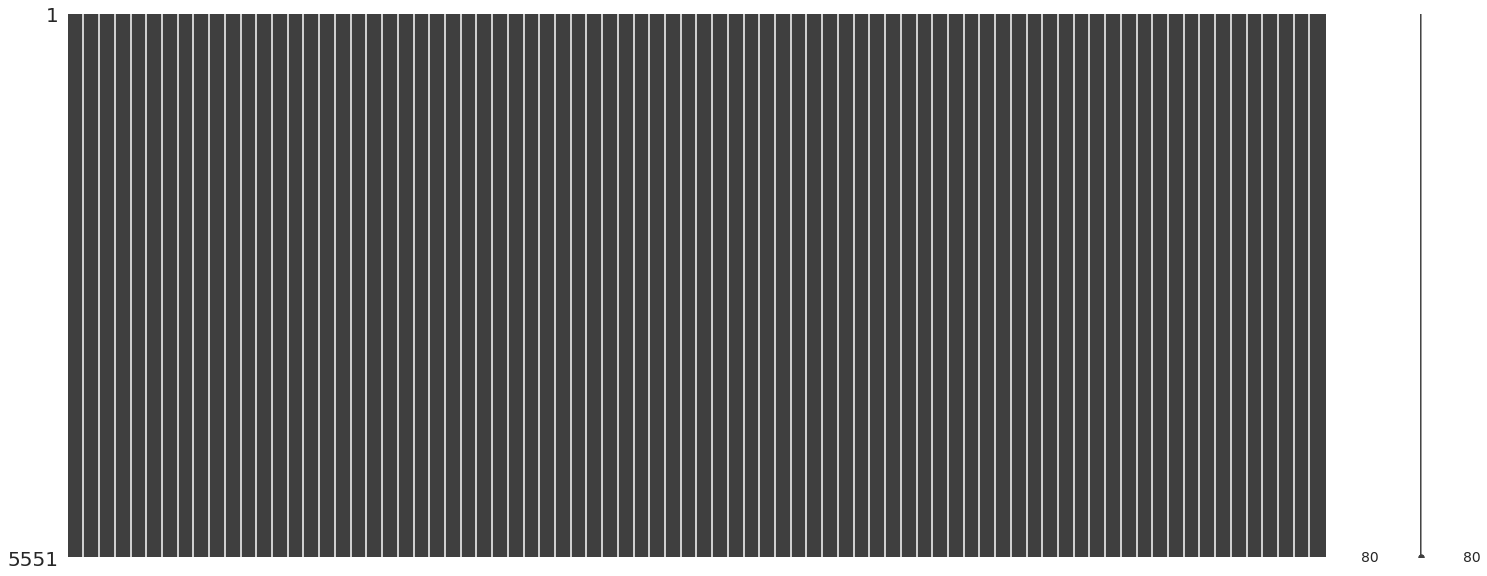

In [14]:
msno.matrix(result)

In [15]:
# rimetto i valori nan che erano stati imputati a nan
result.loc[result['Outcome'] == -1, 'Outcome'] = np.nan

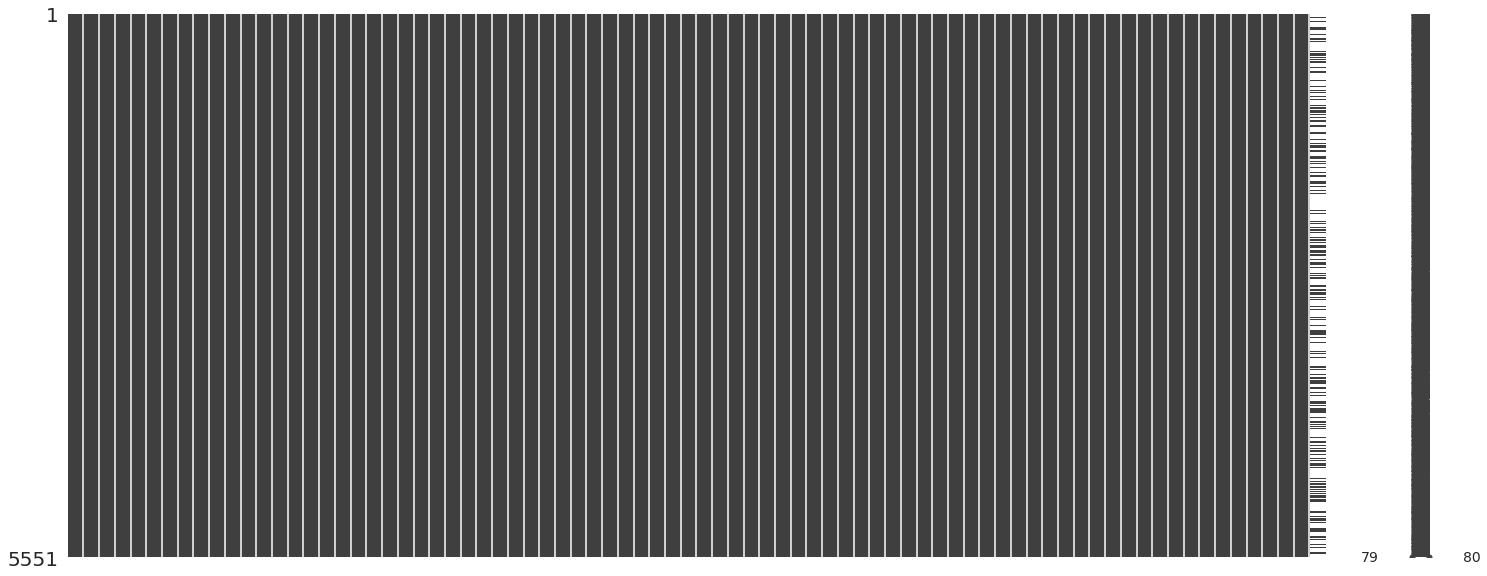

In [16]:
msno.matrix(result)

In [17]:
for col in result:
    #get dtype for column
    dt = result[col].dtype 
    #check if it is a number
    if col != 'Outcome':
        if dt == int or dt == float:
            result.loc[result[col]<0, col] = np.nan
        else:
            result.loc[result[col] == "", col] = np.nan

In [18]:
msno.matrix(result)

In [19]:
percent_missing = result.isnull().sum() * 100 / len(result)
missing_value_df = pd.DataFrame({'column_name': result.columns,
                                 'percent_missing': percent_missing})

In [20]:
missing_value_df.sort_values('percent_missing', inplace=True)
missing_value_df

column_name  percent_missing
HDN_CODE                              HDN_CODE         0.000000
Sesso                                    Sesso         0.000000
ETA                                        ETA         0.000000
DATA                                      DATA         0.000000
DATA_INT                              DATA_INT         0.000000
...                                        ...              ...
Intrinsic Capacity (%)  Intrinsic Capacity (%)        63.267880
Outcome                                Outcome        67.987750
PCR                                        PCR        78.580436
Neutrofili                          Neutrofili        79.823455
CogStateScore_Esito        CogStateScore_Esito        89.731580

[80 rows x 2 columns]

In [21]:
#X = result[(result['FrailtyPhenotypeBool'].notna()) & (result['Resilience'].notna())]
X = result[(result['Outcome'].notna())]
X.drop(columns=['FrailtyPhenotypeBool', 'Resilience', 'Outcome', 'DATA'], inplace=True)

# = result[(result['FrailtyPhenotypeBool'].notna()) & (result['Resilience'].notna())]['Outcome']
y= result[(result['Outcome'].notna())]['Outcome']

#x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=42)#, test_size=0.25)#, shuffle=False)
skf = StratifiedKFold()

for train_index, test_index in skf.split(X, y):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [22]:
percent_missing = X.isnull().sum() * 100 / len(X)
missing_value_df = pd.DataFrame({'column_name': X.columns,
                                 'percent_missing': percent_missing})
missing_value_df.sort_values('percent_missing', inplace=True)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(missing_value_df['percent_missing'])

HDN_CODE                                      0.000000
DASS21 depression                             0.000000
Stress level                                  0.000000
DASS21 stress                                 0.000000
DifficoltaEconomicheSpeseSanitarie            0.000000
SentirsiSolo                                  0.000000
CaduteUltimoAnno                              0.000000
PersoPeso                                     0.000000
AssumePiuFarmaciGiorno                        0.000000
SF36 general health                           0.000000
DATA_INT                                      0.000000
Sesso                                         0.000000
num_visita                                    0.000000
ETA                                           0.000000
PuoContareSuQualcuno                          0.168824
EQ5D5L                                        0.393922
Depression level                              0.956669
DASS21 anxiety                                1.406866
EQ5D5L hea

In [23]:
# alzare la soglia per includere charlson
perc = 40.0
min_count =  int(((100-perc)/100)*X.shape[0] + 1)
mod_df = X.dropna(axis=1, 
                thresh=min_count)

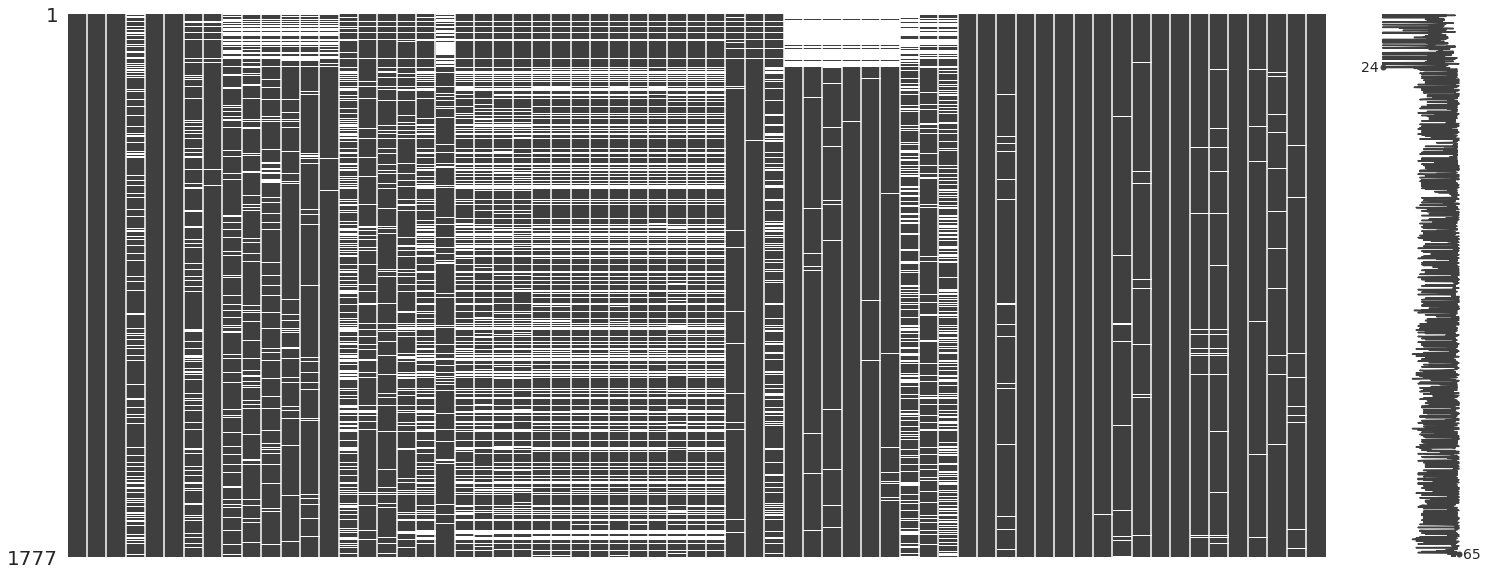

In [24]:
msno.matrix(mod_df)

In [25]:
mod_df.shape

(1777, 65)

In [26]:
set(X.columns) - set(mod_df.columns)

{'Charlson_Diabete',
 'Charlson_Totale',
 'CogStateScore_Esito',
 'Descrizione',
 'EGA_HB',
 'GlobuliBianchi',
 'Neutrofili',
 'PCR',
 'Pneumo_ScalaBorg',
 'TestCammino6Min_BorgBase',
 'TestCammino6Min_BorgEnd'}

In [27]:
y.isna().value_counts()

False    1777
Name: Outcome, dtype: int64

# Test dataset completo

---



In [28]:
# tentativi con i dataset concatenati e senza rimozione dei valori null
'''model = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, #gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=np.nan, #monotone_constraints='()',
              n_estimators=60, n_jobs=8, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=0)

model2 = XGBClassifier(learning_rate=0.05, max_depth=6, n_estimators=180,
              objective='multi:softprob')'''

model = XGBClassifier(max_depth=7, n_estimators=180, objective='multi:softprob')
model2 = XGBClassifier(max_depth=6, objective='multi:softprob')

model.fit(X_train, y_train)
model2.fit(X_train, y_train)

y_test_hat = model.predict(X_test)
y_test_hat_2 = model2.predict(X_test)

# con i nan non funziona 
print("Accuracy modello 1: ", accuracy_score(y_test, y_test_hat))
#print("Accuracy modello 2: ", accuracy_score(y_test, y_test_hat_2))

Accuracy modello 1:  0.8507042253521127


In [29]:
print("cross val modello 1: ", cross_val_score(model, X_train, y_train))
print("E-measure", fbeta_score(y_test, y_test_hat, beta=0.5, average=None))

print("cross val modello 2: ", cross_val_score(model2, X_train, y_train))
print("E-measure", fbeta_score(y_test, y_test_hat_2, beta=0.5, average=None))

cross val modello 1:  [0.84561404 0.8245614  0.83450704 0.82746479 0.85211268]
E-measure [0.71823204 0.8789205  0.90909091 0.77830189]
cross val modello 2:  [0.85964912 0.82807018 0.82746479 0.82746479 0.84859155]
E-measure [0.68322981 0.86847748 0.90909091 0.80882353]


In [30]:
#cross val modello 1:  [0.8164794  0.84644195 0.81203008 0.85338346 0.81578947]
#cross val modello 2:  [0.82022472 0.84269663 0.81954887 0.85714286 0.83082707]
# fare confronto con prestazioni senza data augmentation

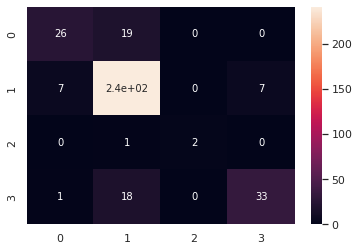

In [31]:
#plot_confusion_matrix(model, x_test, y_test)
#confusion_matrix(y_test, y_test_hat)
df_cm = pd.DataFrame(confusion_matrix(y_test, y_test_hat))
plt.figure()
sns.heatmap(df_cm, annot=True)

# ascissa = reale, ordinata = predetto

In [32]:
parameters = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 260, 40),
    #'learning_rate': [0.1, 0.01, 0.05]
}

In [33]:
grid_search = GridSearchCV(
    estimator=XGBClassifier(),
    param_grid=parameters,
    scoring = 'accuracy',
    n_jobs = 10,
    cv = 10,
    verbose=True
)

In [34]:
# troppo grande per riuscire ad eseguire
import time
start_time = time.time()
grid_search.fit(X_train, y_train)
print("--- %s seconds ---" % (time.time() - start_time))

Fitting 10 folds for each of 40 candidates, totalling 400 fits
--- 1357.9489254951477 seconds ---


In [35]:
grid_search.best_estimator_

XGBClassifier(max_depth=7, n_estimators=180, objective='multi:softprob')

In [36]:
grid_search_fbeta_micro = GridSearchCV(
    estimator=XGBClassifier(),
    param_grid=parameters,
    scoring = make_scorer(fbeta_score, beta=0.5, average='micro'),
    n_jobs = 10,
    cv = 10,
    verbose=True
)

In [37]:
import time
start_time = time.time()
grid_search_fbeta_micro.fit(X_train, y_train)
print("--- %s seconds ---" % (time.time() - start_time))

Fitting 10 folds for each of 40 candidates, totalling 400 fits
--- 1362.8827073574066 seconds ---


In [38]:
grid_search_fbeta_micro.best_estimator_

XGBClassifier(max_depth=7, n_estimators=180, objective='multi:softprob')

In [39]:
grid_search_fbeta_weighted = GridSearchCV(
    estimator=XGBClassifier(),
    param_grid=parameters,
    scoring = make_scorer(fbeta_score, beta=0.5, average='weighted'),
    n_jobs = 10,
    cv = 10,
    verbose=True
)

In [41]:
import time
start_time = time.time()
grid_search_fbeta_weighted.fit(X_train, y_train)
print("--- %s seconds ---" % (time.time() - start_time))

Fitting 10 folds for each of 40 candidates, totalling 400 fits
--- 1349.3651659488678 seconds ---


In [42]:
grid_search_fbeta_weighted.best_estimator_

XGBClassifier(max_depth=6, objective='multi:softprob')

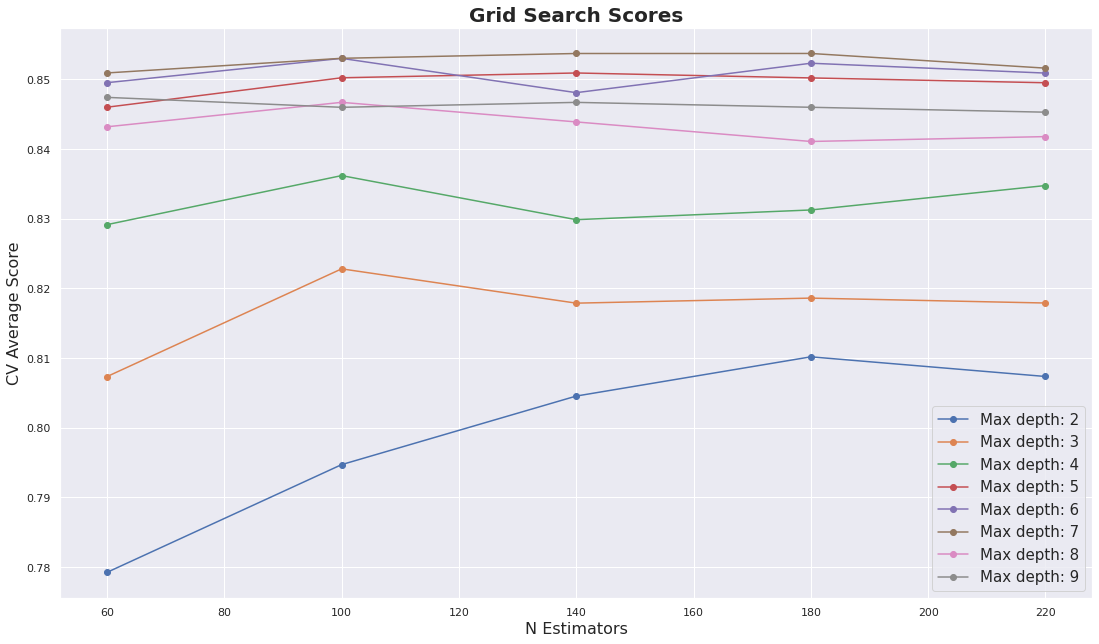

In [43]:
plot_grid_search(grid_search.cv_results_, parameters['n_estimators'], parameters['max_depth'], 'N Estimators', 'Max depth')

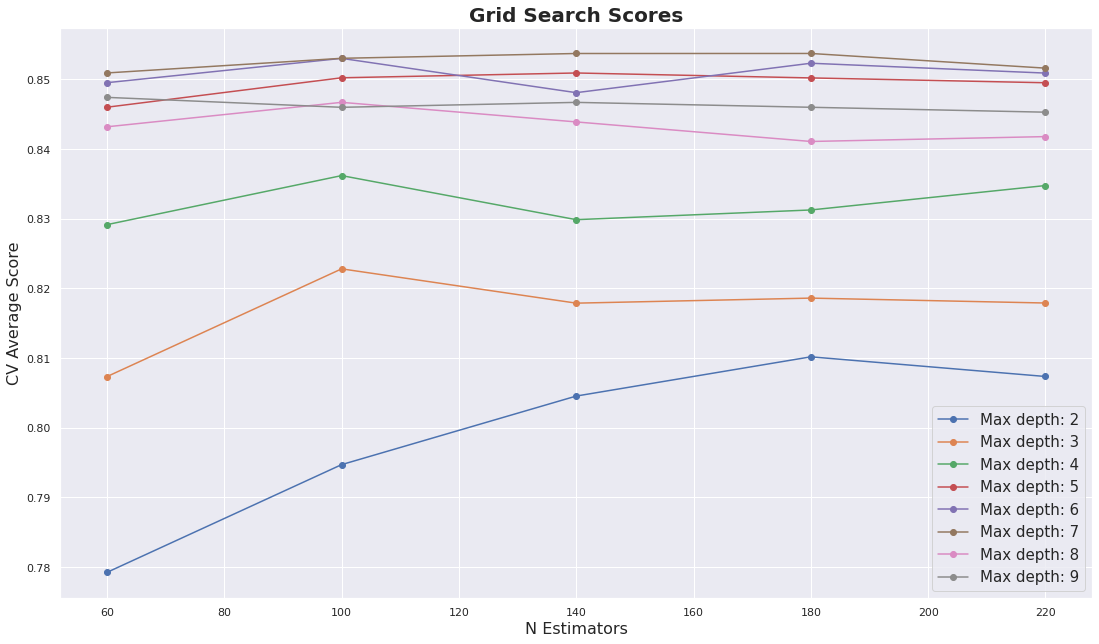

In [44]:
plot_grid_search(grid_search_fbeta_micro.cv_results_, parameters['n_estimators'], parameters['max_depth'], 'N Estimators', 'Max depth')

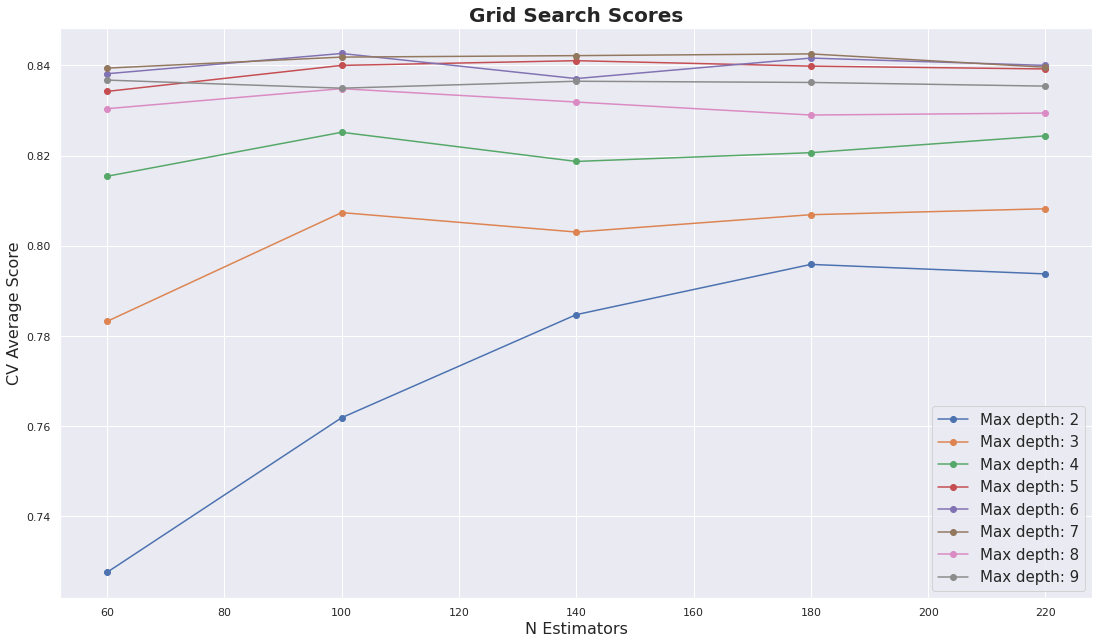

In [45]:
plot_grid_search(grid_search_fbeta_weighted.cv_results_, parameters['n_estimators'], parameters['max_depth'], 'N Estimators', 'Max depth')

In [ ]:
# risultato esecuzione grid search
'''XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=60, n_jobs=8, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
              
  XGBClassifier(learning_rate=0.05, max_depth=6, n_estimators=180,
              objective='multi:softprob', tree_method='gpu_hist')
              
  XGBClassifier(max_depth=7, n_estimators=180, objective='multi:softprob')'''

"XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,\n              importance_type='gain', interaction_constraints='',\n              learning_rate=0.1, max_delta_step=0, max_depth=5,\n              min_child_weight=1, missing=nan, monotone_constraints='()',\n              n_estimators=60, n_jobs=8, num_parallel_tree=1,\n              objective='multi:softprob', random_state=0, reg_alpha=0,\n              reg_lambda=1, scale_pos_weight=None, subsample=1,\n              tree_method='exact', validate_parameters=1, verbosity=None)\n              \n  XGBClassifier(learning_rate=0.05, max_depth=6, n_estimators=180,\n              objective='multi:softprob', tree_method='gpu_hist')\n              \n  XGBClassifier(max_depth=7, n_estimators=180, objective='multi:softprob')"

# Testing con solo dataset iniziale

---



In [46]:
# rimetto i valori nan che erano stati imputati a nan
df.loc[df['Outcome'] == -1, 'Outcome'] = np.nan
for col in result:
    #get dtype for column
    dt = df[col].dtype 
    #check if it is a number
    if col != 'Outcome':
        if dt == int or dt == float:
            df.loc[df[col]<0, col] = np.nan
        else:
            df.loc[df[col] == "", col] = np.nan

In [47]:
# dataset solo iniziale

#X = result[(result['FrailtyPhenotypeBool'].notna()) & (result['Resilience'].notna())]
X_df = df[df['Outcome'].notna()]
X_df.drop(columns=['FrailtyPhenotypeBool', 'Resilience', 'Outcome', 'DATA'], inplace=True)

# = result[(result['FrailtyPhenotypeBool'].notna()) & (result['Resilience'].notna())]['Outcome']
y_df = df[df['Outcome'].notna()]['Outcome']

#x_train_df, x_test_df, y_train_df, y_test_df = train_test_split(X_df, y_df, random_state=42)#, test_size=0.25)#, shuffle=False)

skf = StratifiedKFold()

for train_index, test_index in skf.split(X_df, y_df):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train_df, X_test_df = X_df.iloc[train_index], X_df.iloc[test_index]
    y_train_df, y_test_df = y_df.iloc[train_index], y_df.iloc[test_index]

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  UserWarning,


In [48]:
X_train_df.shape, X_test_df.shape, y_train_df.shape, y_test_df.shape

((141, 76), (35, 76), (141,), (35,))

In [49]:
# provare la E-measure con Beta=0.5
# più è vicino a 1 meglio è, così considero anche gli errori
# è in A6-Evaluation di Gestione dell'Informazione
# elbow method sklearn

model_df = XGBClassifier(max_depth=5, n_estimators=180, objective='multi:softprob')
model_df.fit(X_train_df, y_train_df)

y_test_hat_df = model_df.predict(X_test_df)

print("Accuracy modello: ", accuracy_score(y_test_df, y_test_hat_df))

Accuracy modello:  0.4857142857142857


In [50]:
y_test_df.to_numpy(), y_test_hat_df

(array([2., 1., 0., 1., 1., 1., 1., 0., 1., 1., 3., 1., 1., 1., 3., 1., 1.,
        1., 3., 1., 1., 1., 1., 1., 1., 1., 3., 0., 1., 1., 1., 1., 3., 0.,
        1.]),
 array([1., 1., 0., 1., 1., 1., 1., 0., 3., 3., 1., 1., 1., 3., 1., 1., 1.,
        3., 1., 0., 3., 1., 1., 3., 1., 1., 0., 3., 3., 1., 3., 3., 3., 3.,
        3.]))

In [51]:
print("cross val modello: ", cross_val_score(model_df, X_train_df, y_train_df))
print("E-measure", fbeta_score(y_test_df, y_test_hat_df, beta=0.5, average=None))
print("E-measure", fbeta_score(y_test_df, y_test_hat_df, beta=0.5, average='weighted'))

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


cross val modello:  [0.68965517 0.85714286 0.78571429 0.64285714 0.5       ]
E-measure [0.5        0.72164948 0.         0.0877193 ]
E-measure 0.5851381029894325


In [52]:
parameters2 = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 260, 40),
    #'learning_rate': [0.1, 0.01, 0.05]
}

In [53]:
grid_search_df = GridSearchCV(
    estimator=XGBClassifier(),
    param_grid=parameters2,
    scoring = 'accuracy',
    n_jobs = 10,
    cv = 10,
    verbose=True
)

In [54]:
# troppo grande per riuscire ad eseguire
import time
start_time = time.time()
grid_search_df.fit(X_train_df, y_train_df)
print("--- %s seconds ---" % (time.time() - start_time))

Fitting 10 folds for each of 40 candidates, totalling 400 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  UserWarning,


--- 94.07127666473389 seconds ---


In [55]:
grid_search_df.best_estimator_

XGBClassifier(max_depth=5, n_estimators=180, objective='multi:softprob')

In [56]:
grid_search_fbeta_micro_df = GridSearchCV(
    estimator=XGBClassifier(),
    param_grid=parameters2,
    scoring = make_scorer(fbeta_score, beta=0.5, average='micro'),
    n_jobs = 10,
    cv = 10,
    verbose=True
)

In [57]:
import time
start_time = time.time()
grid_search_fbeta_micro_df.fit(X_train_df, y_train_df)
print("--- %s seconds ---" % (time.time() - start_time))

Fitting 10 folds for each of 40 candidates, totalling 400 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  UserWarning,


--- 94.47704482078552 seconds ---


In [58]:
grid_search_fbeta_micro_df.best_estimator_

XGBClassifier(max_depth=5, n_estimators=180, objective='multi:softprob')

In [59]:
grid_search_fbeta_weighted_df = GridSearchCV(
    estimator=XGBClassifier(),
    param_grid=parameters2,
    scoring = make_scorer(fbeta_score, beta=0.5, average='weighted'),
    n_jobs = 10,
    cv = 10,
    verbose=True
)

In [60]:
import time
start_time = time.time()
grid_search_fbeta_weighted_df.fit(X_train_df, y_train_df)
print("--- %s seconds ---" % (time.time() - start_time))

Fitting 10 folds for each of 40 candidates, totalling 400 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  UserWarning,


--- 93.11020016670227 seconds ---


In [61]:
grid_search_fbeta_weighted_df.best_estimator_

XGBClassifier(n_estimators=60, objective='multi:softprob')

In [62]:
plot_grid_search(grid_search_df.cv_results_, parameters2['n_estimators'], parameters2['max_depth'], 'N Estimators', 'Max depth')

In [63]:
plot_grid_search(grid_search_fbeta_micro_df.cv_results_, parameters2['n_estimators'], parameters2['max_depth'], 'N Estimators', 'Max depth')

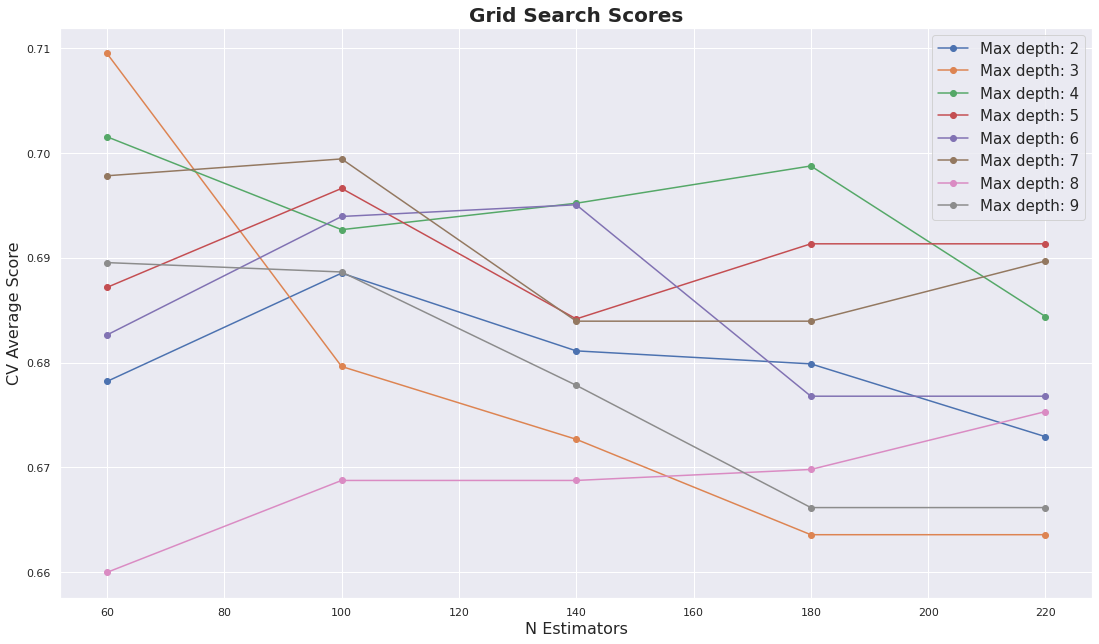

In [64]:
plot_grid_search(grid_search_fbeta_weighted_df.cv_results_, parameters2['n_estimators'], parameters2['max_depth'], 'N Estimators', 'Max depth')

In [65]:
df_cm = pd.DataFrame(confusion_matrix(y_test_df, y_test_hat_df))
plt.figure()
sns.heatmap(df_cm, annot=True)

In [66]:
print(y_test_df.value_counts())

1.0    25
3.0     5
0.0     4
2.0     1
Name: Outcome, dtype: int64
